### Fetch HydroViz data from Geoserver / Rasdaman*

This notebook demonstrates how to fetch the SECASC HydroViz vector data (stream segments and watersheds) from Geoserver using a HUC6 polygon. 

The geometry attributes are then used to query streamflow statistics data from Rasdaman (*coming soon!)

In [1]:
import requests
import xarray as xr
import geopandas as gpd
from matplotlib import pyplot as plt

# set parameters using dev version of Geoserver
base_url = "https://gs.earthmaps.io/geoserver/"
dir = "hydrology"
layers = ["seg", "hru"]
output = "application/json"
wfs_get_string = "/ows?service=WFS&version=1.0.0&request=GetFeature&typeName="

# load HUC6 polygons and transform to match project CRS: EPSG:5070 (NAD83 / Conus Albers)
# in this future, this data could also be hosted on Geoserver and accessed via WFS
# chinook
# huc6 = gpd.read_file('/import/beegfs/CMIP6/jdpaul3/hydroviz_data/export/WBDHU6.shp').to_crs('EPSG:5070')
# local
huc6 = gpd.read_file("/Users/joshpaul/secasc_hydroviz/other_gis/HUC/WBDHU6.shp").to_crs(
    "EPSG:5070"
)

DriverError: /Users/joshpaul/secasc_hydroviz/other_gis/HUC/WBDHU6.shp: No such file or directory

In [ ]:
# we will build a function that uses a single polygon to define the bounding box request


def get_bbox_features_and_clip(base_request_string, polygon_gdf):
    # validate geometry
    polygon_gdf["geometry"] = polygon_gdf["geometry"].make_valid()

    # get the bounds of the polygon - expects a gdf with single polygon, return error if not
    if len(polygon_gdf) > 1:
        print(
            "Input polygon gdf has more than one polygon. Please provide a gdf with only one polygon."
        )
        return None  # in the API, return a specific error
    else:
        xmin, ymin, xmax, ymax = polygon_gdf.bounds.values[0]

        # build the bbox string, double checking that the xmin/xmax values are in the correct order
        # this is somewhat redundant but when the projected coordinates are negative, the order can be flipped and produce errors
        bbox_string = (
            str(int(min(xmin, xmax)))
            + ", "
            + str(int(min(ymin, ymax)))
            + ", "
            + str(int(max(xmin, xmax)))
            + ", "
            + str(int(max(ymin, ymax)))
        )

        # create the bbox request string
        bbox_request_string = base_request_string + "&bbox=" + bbox_string

        # also tried this with a CQL filter..."the_geom" is the default geometry field in Geoserver
        # cql_bbox_request_string = base_request_string + "&cql_filter=bbox(the_geom," + bbox_string + ")"

        print(
            f"Fetching data for {polygon_gdf.name.loc[0]} (HUC6: {polygon_gdf.huc6.loc[0]}) using bbox: {bbox_string}"
        )
        print(f"Request URL: {bbox_request_string}")

        # get the features
        with requests.get(
            bbox_request_string, verify=False
        ) as r:  # verify=False is necessary for dev version of Geoserver
            if r.status_code != 200:
                print(
                    "No response from server. Please check the request string and try again."
                )
                return None  # in the API, return a specific error
            else:
                try:
                    r_json = r.json()
                except:
                    print("Unable to decode as JSON. Returning raw text:\n", r.text)
                    return r.text

        # create a valid geodataframe from the features and clip the features to the polygon
        bbox_gdf = gpd.GeoDataFrame.from_features(r_json["features"], crs="EPSG:5070")
        bbox_gdf["geometry"] = bbox_gdf["geometry"].make_valid()

        clipped_gdf = gpd.clip(bbox_gdf, polygon_gdf)

        return clipped_gdf

<Axes: >

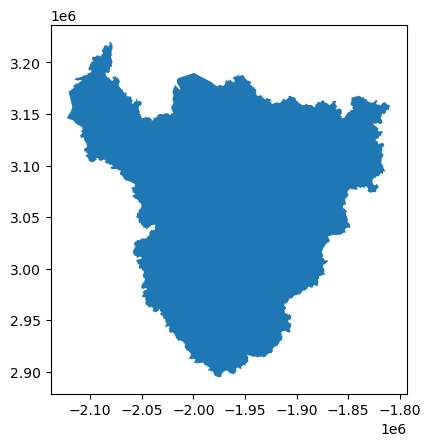

In [ ]:
# let's test by using the HUC6 for Puget Sound
puget_huc6 = huc6[huc6["name"] == "Puget Sound"][
    ["name", "huc6", "geometry"]
].reset_index(drop=True)
puget_huc6.plot()

In [ ]:
# and build basic feature request strings for the two geometries
# these would get all the features, but that request would definitely fail due to the size of the file!

request_strings = [
    base_url + dir + wfs_get_string + dir + ":" + layers[0] + "&outputFormat=" + output,
    base_url + dir + wfs_get_string + dir + ":" + layers[1] + "&outputFormat=" + output,
]

print(request_strings[0])
print(request_strings[1])

https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:seg&outputFormat=application/json
https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:hru&outputFormat=application/json


In [ ]:
# get the features
puget_segments = get_bbox_features_and_clip(request_strings[0], puget_huc6)
puget_watersheds = get_bbox_features_and_clip(request_strings[1], puget_huc6)

Fetching data for Puget Sound (HUC6: 171100) using bbox: -2122635, 2894750, -1809114, 3220385
Request URL: https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:seg&outputFormat=application/json&bbox=-2122635, 2894750, -1809114, 3220385


/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gs.earthmaps.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Fetching data for Puget Sound (HUC6: 171100) using bbox: -2122635, 2894750, -1809114, 3220385
Request URL: https://gs.earthmaps.io/geoserver/hydrology/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=hydrology:hru&outputFormat=application/json&bbox=-2122635, 2894750, -1809114, 3220385


/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gs.earthmaps.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/shapely/constructive.py:542: RuntimeWarning: invalid value encountered in make_valid
  return lib.make_valid(geometry, **kwargs)
/Users/joshpaul/miniconda3/envs/snap-geo/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<Axes: >

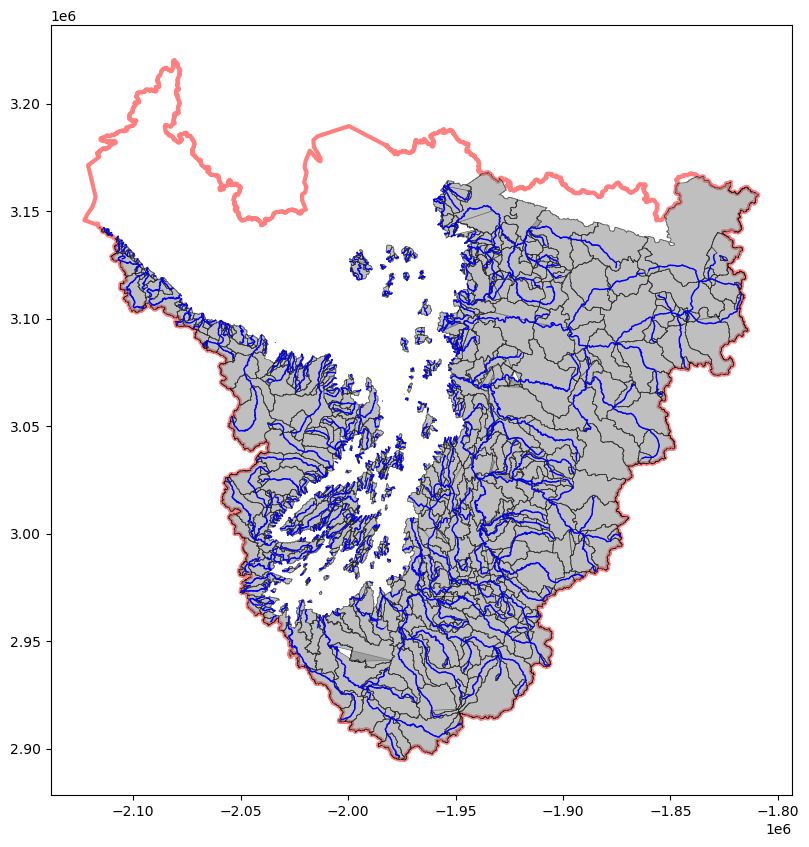

In [ ]:
# plot the features enclosed within the HUC6 polygon

fig, ax = plt.subplots(figsize=(10, 10))

puget_segments.plot(ax=ax, color="blue", linewidth=1, zorder=2)
puget_watersheds.plot(
    ax=ax, facecolor="gray", edgecolor="black", linewidth=0.5, alpha=0.5, zorder=1
)
puget_huc6.plot(
    ax=ax, facecolor="none", edgecolor="red", linewidth=3, alpha=0.5, zorder=0
)

In [ ]:
# you can see some weird geometric artifacts in the watershed polygons...
# this is why they require validation inside of the function!
# probably artifacts of the raster > vector conversion process, or perhaps shapefile > geopackage conversion?

In [ ]:
# we can then use these IDs to query the stream flow data from the datacube on rasdaman
print(puget_segments["seg_id_nat"])
print(puget_watersheds["hru_id_nat"])

732     51650
730     51648
563     51481
725     51643
727     51645
        ...  
1309    53374
1266    53331
1272    53337
1268    53333
1310    53375
Name: seg_id_nat, Length: 945, dtype: int64
178     100297
238     100374
215     100345
360     100521
236     100372
         ...  
1822    102237
1824    102239
1857    102272
1894    102309
1939    102356
Name: hru_id_nat, Length: 1842, dtype: int64


In [ ]:
# test of stream segments coverage
# set the request parameters
coverage_id = "conus_hydro_segments_crstephenson"
var = "dh3"
lc = ""

In [ ]:
f"https://zeus.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID={coverage_id}&SUBSET=lc(0)&SUBSET=era(0)&SUBSET=model(0)&SUBSET=scenario(0)&SUBSET=geom_id(1)&RANGESUBSET={var}&FORMAT=application/netcdf"

In [ ]:
# here is what what an API response could potentially look like
# a list of regions, each with a HUC6 name, HUC6 ID, a dictionary of watershed and segment data, and a feature collection of watershed and segment geometries
[
    {
        "name": "Puget Sound",
        "huc6": "171100",
        "data": {
            "watershed_data": {
                {
                    "hru_id": "12345",
                    "landcover": {
                        "model": {
                            "scenario": {
                                "era": {
                                    "stat": {
                                        # hydroviz data goes here
                                        "fl1": 30.5,
                                        "ma1": 10.5,
                                        "dh8": 5.5,
                                    },
                                },
                            },
                        },
                    },
                },
            },
            "segment_data": {
                {
                    "seg_id": "67890",
                    "landcover": {
                        "model": {
                            "scenario": {
                                "era": {
                                    "stat": {
                                        # hydroviz data goes here
                                        "fl1": 20.5,
                                        "ma1": 14.9,
                                        "dh8": 7.5,
                                    },
                                },
                            },
                        },
                    },
                },
            },
            "features": {
                "watershed_geometry": {
                    {
                        "type": "FeatureCollection",
                        "features": [
                            {
                                "type": "Feature",
                                "id": "nhm_hru.1",
                                "geometry": {
                                    "type": "MultiPolygon",
                                    "coordinates": [  # not real coords, just an example
                                        [
                                            [
                                                [492540.3905134, 1190004.05424627],
                                                [492560.23562589, 1189986.95983551],
                                                [492551.38172032, 1189975.93152857],
                                                [492531.52110782, 1189964.75452153],
                                                [492475.35017245, 1189955.8136159],
                                                [492448.06475528, 1189957.99011727],
                                                [492435.11644712, 1189966.72362277],
                                                [492433.53204613, 1189981.7014322],
                                                [492456.93416086, 1189997.28974202],
                                                [492512.32519573, 1190004.12924632],
                                                [492540.3905134, 1190004.05424627],
                                            ]
                                        ]
                                    ],
                                },
                                "geometry_name": "the_geom",
                                "properties": {"hru_id": "12345"},
                            },
                        ],
                        "totalFeatures": 1,
                        "crs": {
                            "type": "name",
                            "properties": {"name": "urn:ogc:def:crs:EPSG::5070"},
                        },
                    },
                },
                "segment_geometry": {
                    {
                        "type": "FeatureCollection",
                        "features": [
                            {
                                "type": "Feature",
                                "id": "nhm_seg.1",
                                "geometry": {
                                    "type": "MultiLineString",
                                    "coordinates": [  # not real coords, just an example
                                        [
                                            [492540.3905134, 1190004.05424627],
                                            [492560.23562589, 1189986.95983551],
                                            [492551.38172032, 1189975.93152857],
                                            [492531.52110782, 1189964.75452153],
                                            [492475.35017245, 1189955.8136159],
                                            [492448.06475528, 1189957.99011727],
                                            [492435.11644712, 1189966.72362277],
                                            [492433.53204613, 1189981.7014322],
                                            [492456.93416086, 1189997.28974202],
                                            [492512.32519573, 1190004.12924632],
                                            [492540.3905134, 1190004.05424627],
                                        ]
                                    ],
                                },
                                "geometry_name": "the_geom",
                                "properties": {"seg_id": "67890"},
                            },
                        ],
                        "totalFeatures": 1,
                        "crs": {
                            "type": "name",
                            "properties": {"name": "urn:ogc:def:crs:EPSG::5070"},
                        },
                    },
                },
            },
        },
    },
    # possible to have more regions as additional list items
]

In [84]:
hru = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/export/hru.shp")

In [90]:
hru.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [91]:
seg = gpd.read_file("/import/beegfs/CMIP6/jdpaul3/hydroviz_data/export/seg.shp")

In [92]:
seg.crs

<Projected CRS: ESRI:102039>
Name: USA_Contiguous_Albers_Equal_Area_Conic_USGS_version
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [107]:
from pyproj import CRS

crs1 = CRS("ESRI:102039")
crs2 = CRS("EPSG:5070")

print(crs1.to_proj4())
print(crs2.to_proj4())

print(crs1 == crs2)

+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
True


/home/jdpaul3/miniconda3/envs/snap-geo/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
